In [1]:
# %load LGB_Mengfei_multi_ridge_LB_0.2217.py
from nltk.corpus import stopwords 
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold
from sklearn.linear_model import Ridge
from scipy.sparse import hstack, csr_matrix
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import gc, re
from sklearn.utils import shuffle
from contextlib import contextmanager
from sklearn.externals import joblib
import pickle

debug = False
print("loading data ...")
used_cols = ["item_id", "user_id"]
if debug == False:
    train_df = pd.read_csv('input/train.csv', parse_dates = ['activation_date'])
    y = train_df["deal_probability"]
    test_df = pd.read_csv('input/test.csv', parse_dates = ['activation_date'])
    # suppl
    train_active = pd.read_csv('input/train_active.csv', usecols=used_cols)
    test_active = pd.read_csv('input/test_active.csv', usecols=used_cols)
    train_periods = pd.read_csv('input/periods_train.csv', parse_dates=["activation_date", "date_from", "date_to"])
    test_periods = pd.read_csv('input/periods_test.csv', parse_dates=["activation_date", "date_from", "date_to"])
    #TODO new class#######################################
#    new_class = pd.read_csv("new_image_class_f600000.csv")
else:
    train_df = pd.read_csv('input/train.csv', parse_dates = ['activation_date'])
    train_df = shuffle(train_df, random_state=1234); train_df = train_df.iloc[:5000]
    y = train_df["deal_probability"]
    test_df = pd.read_csv('input/test.csv', nrows=1000, parse_dates = ['activation_date'])
    # suppl 
    train_active = pd.read_csv('input/train_active.csv', nrows=1000, usecols=used_cols)
    test_active = pd.read_csv('input/test_active.csv', nrows=1000, usecols=used_cols)
    train_periods = pd.read_csv('input/periods_train.csv', nrows=1000, parse_dates=["activation_date", "date_from", "date_to"])
    test_periods = pd.read_csv('input/periods_test.csv', nrows=1000, parse_dates=["activation_date", "date_from", "date_to"])
    #TODO new class#######################################
#    new_class = pd.read_csv("new_image_class_f600000.csv")
print("loading data done!")

# =============================================================================
# Here Based on https://www.kaggle.com/bminixhofer/aggregated-features-lightgbm/code
# =============================================================================
all_samples = pd.concat([train_df,train_active,test_df,test_active]).reset_index(drop=True)
all_samples.drop_duplicates(["item_id"], inplace=True)
del train_active, test_active; gc.collect()

all_periods = pd.concat([train_periods,test_periods])
del train_periods, test_periods; gc.collect()

all_periods["days_up"] = (all_periods["date_to"] - all_periods["date_from"]).dt.days
gp = all_periods.groupby(["item_id"])[["days_up"]]

#TODO####################################################
all_periods["days_wait"] = (all_periods["date_from"] - all_periods["activation_date"]).dt.days
#gp2 = all_periods.groupby(["item_id"])[["days_wait"]]

gp_df = pd.DataFrame()
gp_df["days_up_sum"] = gp.sum()["days_up"]
gp_df["times_put_up"] = gp.count()["days_up"]
#TODO####################################################
#gp_df["days_wait_sum"] = gp2.sum()["days_wait"]
#gp_df["times_put_wait"] = gp2.count()["days_wait"]

del gp; gc.collect()

gp_df.reset_index(inplace=True)
gp_df.rename(index=str, columns={"index": "item_id"})

all_periods.drop_duplicates(["item_id"], inplace=True)
all_periods = all_periods.merge(gp_df, on="item_id", how="left")
all_periods = all_periods.merge(all_samples, on="item_id", how="left")


gp = all_periods.groupby(["user_id"])[["days_up_sum", "times_put_up"]].mean().reset_index()\
.rename(index=str, columns={"days_up_sum": "avg_days_up_user",
                            "times_put_up": "avg_times_up_user"})
#TODO####################################################

#gp2 = all_periods.groupby(["user_id"])[["days_wait_sum", "times_put_wait"]].mean().reset_index()\
#.rename(index=str, columns={"days_wait_sum": "avg_days_wait_user",
#                            "times_put_wait": "avg_times_wait_user"})


n_user_items = all_samples.groupby(["user_id"])[["item_id"]].count().reset_index() \
.rename(index=str, columns={"item_id": "n_user_items"})
gp = gp.merge(n_user_items, on="user_id", how="outer") #left

#gp = gp.merge(gp2, on="user_id", how="outer")

del all_samples, all_periods, n_user_items
gc.collect()

train_df = train_df.merge(gp, on="user_id", how="left")
test_df = test_df.merge(gp, on="user_id", how="left")

agg_cols = list(gp.columns)[1:]

del gp; gc.collect()

for col in agg_cols:
    train_df[col].fillna(-1, inplace=True)
    test_df[col].fillna(-1, inplace=True)

print("merging supplimentary data done!")


# =============================================================================
# done! go to the normal steps
# =============================================================================
def rmse(predictions, targets):
    print("calculating RMSE ...")
    return np.sqrt(((predictions - targets) ** 2).mean())

def text_preprocessing(text):        
    text = str(text)
    text = text.lower() 
    # hash words
    text = re.sub(r"(\\u[0-9A-Fa-f]+)",r"", text)
    
    text = re.sub(r"===",r" ", text)
    
    # https://www.kaggle.com/demery/lightgbm-with-ridge-feature/code
    text = " ".join(map(str.strip, re.split('(\d+)',text)))
    regex = re.compile(u'[^[:alpha:]]')
    text = regex.sub(" ", text)
    text = " ".join(text.split())
    return text

@contextmanager
def feature_engineering(df):
    # All the feature engineering here  
    
    def Do_Text_Hash(df):
        print("feature engineering -> hash text ...")
        df["text_feature"] = df.apply(lambda row: " ".join([str(row["param_1"]),
          str(row["param_2"]), str(row["param_3"])]),axis=1)
    
        df["text_feature_2"] = df.apply(lambda row: " ".join([str(row["param_2"]), str(row["param_3"])]),axis=1)        
        df["title_description"] = df.apply(lambda row: " ".join([str(row["title"]), str(row["description"])]),axis=1)
       
        print("feature engineering -> preprocess text ...")       
        df["text_feature"] = df["text_feature"].apply(lambda x: text_preprocessing(x))
        df["text_feature_2"] = df["text_feature_2"].apply(lambda x: text_preprocessing(x))
        df["description"] = df["description"].apply(lambda x: text_preprocessing(x))
        df["title"] = df["title"].apply(lambda x: text_preprocessing(x))
        df["title_description"] = df["title_description"].apply(lambda x: text_preprocessing(x))
                       
    def Do_Datetime(df):
        print("feature engineering -> date time ...")
        df["wday"] = df["activation_date"].dt.weekday
#        df["week"] = df["activation_date"].dt.week
#        df["dom"] = df["activation_date"].dt.day
        
    def Do_Label_Enc(df):
        print("feature engineering -> lable encoding ...")
        lbl = LabelEncoder()
        #TODO new class#######################################
        cat_col = ["user_id", "region", "city", "parent_category_name",
               "category_name", "user_type", 'image_top_1',
               "param_1", "param_2", "param_3", 'image']
        for col in cat_col:
            df[col] = lbl.fit_transform(df[col].astype(str))
            gc.collect()
    
    import string
    count = lambda l1,l2: sum([1 for x in l1 if x in l2])         
    def Do_NA(df):
        print("feature engineering -> fill na ...")
#        df["price"] = np.log(df["price"]+0.001).astype("float32")
#        df["price"].fillna(-1,inplace=True)
#        df["image_top_1"].fillna(-1,inplace=True)
#        df["image_top_4"].fillna(-1,inplace=True)
        df["image"].fillna("noinformation",inplace=True)
        df["param_1"].fillna("nicapotato",inplace=True)
        df["param_2"].fillna("nicapotato",inplace=True)
        df["param_3"].fillna("nicapotato",inplace=True)
        df["title"].fillna("nicapotato",inplace=True)
        df["description"].fillna("nicapotato",inplace=True)
        
    def Do_Count(df):  
        print("feature engineering -> do count ...")
        # some count       
        df["num_desc_punct"] = df["description"].apply(lambda x: count(x, set(string.punctuation)))
        df["num_desc_capE"] = df["description"].apply(lambda x: count(x, "[A-Z]"))
        df["num_desc_capP"] = df["description"].apply(lambda x: count(x, "[А-Я]"))
        
        df["num_title_punct"] = df["title"].apply(lambda x: count(x, set(string.punctuation)))
        df["num_title_capE"] = df["title"].apply(lambda x: count(x, "[A-Z]"))
        df["num_title_capP"] = df["title"].apply(lambda x: count(x, "[А-Я]"))               
        # good, used, bad ... count
        df["is_in_desc_хорошо"] = df["description"].str.contains("хорошо").map({True:1, False:0})
        df["is_in_desc_Плохо"] = df["description"].str.contains("Плохо").map({True:1, False:0})
        df["is_in_desc_новый"] = df["description"].str.contains("новый").map({True:1, False:0})
        df["is_in_desc_старый"] = df["description"].str.contains("старый").map({True:1, False:0})
        df["is_in_desc_используемый"] = df["description"].str.contains("используемый").map({True:1, False:0})
        df["is_in_desc_есплатная_доставка"] = df["description"].str.contains("есплатная доставка").map({True:1, False:0})
        df["is_in_desc_есплатный_возврат"] = df["description"].str.contains("есплатный возврат").map({True:1, False:0})
        df["is_in_desc_идеально"] = df["description"].str.contains("идеально").map({True:1, False:0})
        df["is_in_desc_подержанный"] = df["description"].str.contains("подержанный").map({True:1, False:0})
        df["is_in_desc_пСниженные_цены"] = df["description"].str.contains("Сниженные цены").map({True:1, False:0})
        
                              
    def Do_Drop(df):
        df.drop(["activation_date", "item_id"], axis=1, inplace=True)
        
    def Do_Stat_Text(df):
        print("feature engineering -> statistics in text ...")
        textfeats = ["text_feature","text_feature_2","description", "title"]
        for col in textfeats:
            df[col + "_num_chars"] = df[col].apply(len) 
            df[col + "_num_words"] = df[col].apply(lambda comment: len(comment.split()))
            df[col + "_num_unique_words"] = df[col].apply(lambda comment: len(set(w for w in comment.split())))
            df[col + "_words_vs_unique"] = df[col+"_num_unique_words"] / df[col+"_num_words"] * 100
            gc.collect()
                      
    # choose which functions to run
    Do_NA(df)
    Do_Text_Hash(df)
    Do_Label_Enc(df)
    Do_Count(df)
    Do_Datetime(df)   
    Do_Stat_Text(df)       
    Do_Drop(df)    
    gc.collect()
    return df

def data_vectorize(df):
    russian_stop = set(stopwords.words("russian"))
    tfidf_para = {
    "stop_words": russian_stop,
    "analyzer": "word",
    "token_pattern": r"\w{1,}",
    "sublinear_tf": True,
    "dtype": np.float32,
    "norm": "l2",
    #"min_df":5,
    #"max_df":.9,
    "smooth_idf":False
    }
    def get_col(col_name): return lambda x: x[col_name]
    vectorizer = FeatureUnion([
        ("description", TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=18000,
            **tfidf_para,
            preprocessor=get_col("description"))
         ),
        ("title_description", TfidfVectorizer(
            ngram_range=(1, 2),
            max_features=18000,
            **tfidf_para,
            preprocessor=get_col("title_description"))
         ),
        ("text_feature", CountVectorizer(
            ngram_range=(1, 2),
            preprocessor=get_col("text_feature"))
         ),
        ("title", TfidfVectorizer(
            ngram_range=(1, 2),
            **tfidf_para,
            preprocessor=get_col("title"))
         ),
    ])
    vectorizer.fit(df.to_dict("records"))
    ready_full_df = vectorizer.transform(df.to_dict("records"))    
    tfvocab = vectorizer.get_feature_names()    
    df.drop(["text_feature", "text_feature_2", "description","title", "title_description"], axis=1, inplace=True)
    df.fillna(-1, inplace=True)     
    return df, ready_full_df, tfvocab
# =============================================================================
# Ridge feature https://www.kaggle.com/demery/lightgbm-with-ridge-feature/code
# =============================================================================
class SklearnWrapper(object):
    def __init__(self, clf, seed=0, params=None, seed_bool = True):
        if(seed_bool == True):
            params['random_state'] = seed
        self.clf = clf(**params)

    def train(self, x_train, y_train):
        self.clf.fit(x_train, y_train)

    def predict(self, x):
        return self.clf.predict(x)

NFOLDS = 10#5
SEED = 42
def get_oof(clf, x_train, y, x_test):
            
    oof_train = np.zeros((len_train,))
    oof_test = np.zeros((len_test,))
    oof_test_skf = np.empty((NFOLDS, len_test))

    for i, (train_index, test_index) in enumerate(kf):
        print('Ridege oof Fold {}'.format(i))
        x_tr = x_train[train_index]       
        y = np.array(y)
        y_tr = y[train_index]
        x_te = x_train[test_index]      
        clf.train(x_tr, y_tr)       
        oof_train[test_index] = clf.predict(x_te)        
        oof_test_skf[i, :] = clf.predict(x_test)
    oof_test[:] = oof_test_skf.mean(axis=0)
    return oof_train.reshape(-1, 1), oof_test.reshape(-1, 1)


full_df = pd.concat([train_df, test_df])
#TODO new class#######################################
#full_df = pd.merge(full_df, new_class, how='left', on=['image_top_1'])
#full_df["new_class"].fillna("beijing",inplace=True)
#print(full_df.head())
sub_item_id = test_df["item_id"]
len_train = len(train_df)
len_test = len(test_df)

kf = KFold(len_train, n_folds=NFOLDS, shuffle=True, random_state=SEED)
# =============================================================================
# handle price
# =============================================================================
def feature_Eng_On_Price_SEQ(df):
    print('feature engineering -> on price and SEQ ...')        
    df["price"] = np.log(df["price"]+0.001).astype("float32")
    df["price"].fillna(-1,inplace=True)     
    df["price+"] = np.round(df["price"]*4.8).astype(int)   
    df["item_seq_number+"] = np.round(df["item_seq_number"]/100).astype(int) 
    return df

train_df, val_df = train_test_split(
    full_df.iloc[:len_train], test_size=0.1, random_state=42) #23    
def feature_Eng_On_Deal_Prob(df, df_train):
    print('feature engineering -> on price deal prob +...')
    df2 = df    
    tmp = df_train.groupby(["price+"], as_index=False)['deal_probability'].median().rename(columns={'deal_probability':'median_deal_probability_price+'})     
    df = pd.merge(df, tmp, how='left', on=["price+"])
    df2['median_deal_probability_price+'] = df['median_deal_probability_price+']  
    del tmp; gc.collect()
    
    tmp = df_train.groupby(["item_seq_number+"], as_index=False)['deal_probability'].median().rename(columns={'deal_probability':'median_deal_probability_item_seq_number+'})     
    df = pd.merge(df, tmp, how='left', on=["item_seq_number+"])
    df2['median_deal_probability_item_seq_number+'] = df['median_deal_probability_item_seq_number+']
    
    #TODO################################################
#    tmp = df_train.groupby(["parent_category_name"], as_index=False)['deal_probability'].median().rename(columns={'deal_probability':'median_deal_probability_parent_category_name'})     
#    df = pd.merge(df, tmp, how='left', on=["parent_category_name"])
#    df2['median_deal_probability_parent_category_name'] = df['median_deal_probability_parent_category_name']
    
#    tmp = df_train.groupby(["category_name"], as_index=False)['deal_probability'].median().rename(columns={'deal_probability':'median_deal_probability_category_name'})     
#    df = pd.merge(df, tmp, how='left', on=["category_name"])
#    df2['median_deal_probability_category_name'] = df['median_deal_probability_category_name']

#    tmp = df_train.groupby(["user_type"], as_index=False)['deal_probability'].median().rename(columns={'deal_probability':'median_deal_probability_user_type'})     
#    df = pd.merge(df, tmp, how='left', on=["user_type"])
#    df2['median_deal_probability_user_type'] = df['median_deal_probability_user_type']
    
    tmp = df_train.groupby(["image_top_1"], as_index=False)['deal_probability'].median().rename(columns={'deal_probability':'median_deal_probability_image_top_1'})     
    df = pd.merge(df, tmp, how='left', on=["image_top_1"])
    df2['median_deal_probability_image_top_1'] = df['median_deal_probability_image_top_1']
    
#    tmp = df_train.groupby(["param_1"], as_index=False)['deal_probability'].median().rename(columns={'deal_probability':'median_deal_probability_param_1'})     
#    df = pd.merge(df, tmp, how='left', on=["param_1"])
#    df2['median_deal_probability_param_1'] = df['median_deal_probability_param_1']
    
#    tmp = df_train.groupby(["param_2"], as_index=False)['deal_probability'].median().rename(columns={'deal_probability':'median_deal_probability_param_2'})     
#    df = pd.merge(df, tmp, how='left', on=["param_2"])
#    df2['median_deal_probability_param_2'] = df['median_deal_probability_param_2']
       
    df2.fillna(-1, inplace=True)    
    del tmp; gc.collect()
    return df2

del full_df['deal_probability']; gc.collect()

# =============================================================================
# use additianl image data
# =============================================================================
feature_engineering(full_df)

feature_Eng_On_Price_SEQ(full_df)
feature_Eng_On_Price_SEQ(train_df)
feature_Eng_On_Deal_Prob(full_df, train_df)

del train_df, test_df; gc.collect()
full_df, ready_full_df, tfvocab = data_vectorize(full_df)

#'alpha':20.0
ridge_params = {'alpha':20.0, 'fit_intercept':True, 'normalize':False, 'copy_X':True,
                'max_iter':None, 'tol':0.001, 'solver':'auto', 'random_state':SEED}
ridge = SklearnWrapper(clf=Ridge, seed = SEED, params = ridge_params)
ready_df = ready_full_df

print('ridge 1 oof ...')
ridge_oof_train, ridge_oof_test = get_oof(ridge, np.array(full_df)[:len_train], y, np.array(full_df)[len_train:])
ridge_preds = np.concatenate([ridge_oof_train, ridge_oof_test])
full_df['ridge_preds_1'] = ridge_preds
full_df['ridge_preds_1'].clip(0.0, 1.0, inplace=True)

print('ridge 2 oof ...')
ridge_oof_train, ridge_oof_test = get_oof(ridge, ready_df[:len_train], y,   ready_df[len_train:])
ridge_preds = np.concatenate([ridge_oof_train, ridge_oof_test])
full_df['ridge_preds_2'] = ridge_preds
full_df['ridge_preds_2'].clip(0.0, 1.0, inplace=True)


# Combine Dense Features with Sparse Text Bag of Words Features
X = hstack([csr_matrix(full_df.iloc[:len_train]), ready_full_df[:len_train]]) # Sparse Matrix
test = hstack([csr_matrix(full_df.iloc[len_train:]), ready_full_df[len_train:]]) # Sparse Matrix
tfvocab = full_df.columns.tolist() + tfvocab

print('Saving pickled data')
with open('X2.p', 'wb') as f:
    pickle.dump(X, f)   
with open('test2.p', 'wb') as f:
    pickle.dump(test, f)   
with open('tfvocab2.p', 'wb') as f:
    pickle.dump(tfvocab, f)
with open('y2.p', 'wb') as f:
    pickle.dump(y, f)


print("Modeling Stage ...")
for shape in [X,test]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ",len(tfvocab))
#TODO new class#######################################
cat_col = [
           "user_id",
           "region", 
           "city", 
           "parent_category_name",
           "category_name", 
           "user_type", 
           "image_top_1",
           "param_1", 
           "param_2", 
           "param_3",
           "price+",
           "item_seq_number+",
#           "new_class"
           ]

rmse_sume = 0.

for numIter in range(0, 1):
      
      X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42) #23
      
#      X_train, X_valid = X.tocsr()[train_index], X.tocsr()[test_index]
#      y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
     
      lgbm_params =  {
              "tree_method": "feature",    
              "num_threads": 12,
              "task": "train",
              "boosting_type": "gbdt",
              "objective": "regression",
              "metric": "rmse",
      #        "max_depth": 15,
              "num_leaves": 500,
              "feature_fraction": 0.2, # 0.4
              "bagging_fraction": 0.2, # 0.4
              "learning_rate": 0.015,
              "verbose": -1,
              'lambda_l1':1,
              'lambda_l2':1,
              }
      
      lgtrain = lgb.Dataset(X_train, y_train,
                      feature_name=tfvocab,
                      categorical_feature = cat_col)
      lgvalid = lgb.Dataset(X_valid, y_valid,
                      feature_name=tfvocab,
                      categorical_feature = cat_col)
      lgb_clf = lgb.train(
              lgbm_params,
              lgtrain,
              num_boost_round=32000,
              valid_sets=[lgtrain, lgvalid],
              valid_names=["train","valid"],
              early_stopping_rounds=200,
              verbose_eval=100, #200
              )
      
      print("save model ...")
      joblib.dump(lgb_clf, "lgb_{}.pkl".format(numIter))
      ## load model
      #lgb_clf = joblib.load("lgb.pkl")
      
      print("Model Evaluation Stage")
      print( "RMSE:", rmse(y_valid, lgb_clf.predict(X_valid, num_iteration=lgb_clf.best_iteration)) )
      lgpred = lgb_clf.predict(test, num_iteration=lgb_clf.best_iteration)
      
      lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=sub_item_id)
      lgsub["deal_probability"].clip(0.0, 1.0, inplace=True) # Between 0 and 1
      lgsub.to_csv("ml_lgb_sub_{}.csv".format(numIter),index=True,header=True)

      rmse_sume += rmse(y_valid, lgb_clf.predict(X_valid, num_iteration=lgb_clf.best_iteration))
      
      numIter += 1
      
      del X_train, X_valid, y_train, y_valid, lgtrain, lgvalid
      gc.collect()

print("mean rmse is:", rmse_sume/5)
      
print("Features importance...")
bst = lgb_clf
gain = bst.feature_importance("gain")
ft = pd.DataFrame({"feature":bst.feature_name(), "split":bst.feature_importance("split"), "gain":100 * gain / gain.sum()}).sort_values("gain", ascending=False)
print(ft.head(50))

plt.figure()
ft[["feature","gain"]].head(50).plot(kind="barh", x="feature", y="gain", legend=False, figsize=(10, 20))
plt.gcf().savefig("features_importance.png")

print("Done.")


"""
mean rmse is: 0.21697176669518864
"""

/home/qifeng/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


loading data ...
loading data done!
merging supplimentary data done!
feature engineering -> fill na ...
feature engineering -> hash text ...
feature engineering -> preprocess text ...
feature engineering -> lable encoding ...
feature engineering -> do count ...
feature engineering -> date time ...
feature engineering -> statistics in text ...
feature engineering -> on price and SEQ ...
feature engineering -> on price and SEQ ...
feature engineering -> on price deal prob +...
ridge 1 oof ...
Ridege oof Fold 0


/home/qifeng/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.538295030216035e-17 / 1.1102230246251565e-16
  RuntimeWarning)


Ridege oof Fold 1


/home/qifeng/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.5398064002656086e-17 / 1.1102230246251565e-16
  RuntimeWarning)


Ridege oof Fold 2


/home/qifeng/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.540376223360872e-17 / 1.1102230246251565e-16
  RuntimeWarning)


Ridege oof Fold 3


/home/qifeng/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.541159478555689e-17 / 1.1102230246251565e-16
  RuntimeWarning)


Ridege oof Fold 4


/home/qifeng/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.5382829038740236e-17 / 1.1102230246251565e-16
  RuntimeWarning)


Ridege oof Fold 5


/home/qifeng/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.5384640625894137e-17 / 1.1102230246251565e-16
  RuntimeWarning)


Ridege oof Fold 6


/home/qifeng/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.5403575479896826e-17 / 1.1102230246251565e-16
  RuntimeWarning)


Ridege oof Fold 7


/home/qifeng/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.540073493613476e-17 / 1.1102230246251565e-16
  RuntimeWarning)


Ridege oof Fold 8


/home/qifeng/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.540283633624476e-17 / 1.1102230246251565e-16
  RuntimeWarning)


Ridege oof Fold 9


/home/qifeng/anaconda3/lib/python3.6/site-packages/scipy/linalg/basic.py:40: RuntimeWarning: scipy.linalg.solve
Ill-conditioned matrix detected. Result is not guaranteed to be accurate.
Reciprocal condition number/precision: 4.539457698537545e-17 / 1.1102230246251565e-16
  RuntimeWarning)


ridge 2 oof ...
Ridege oof Fold 0
Ridege oof Fold 1
Ridege oof Fold 2
Ridege oof Fold 3
Ridege oof Fold 4
Ridege oof Fold 5
Ridege oof Fold 6
Ridege oof Fold 7
Ridege oof Fold 8
Ridege oof Fold 9
Saving pickled data
Modeling Stage ...
1503424 Rows and 1393781 Cols
508438 Rows and 1393781 Cols
Feature Names Length:  1393781


/home/qifeng/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/qifeng/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


KeyboardInterrupt: 

In [ ]:
from nltk.corpus import stopwords 
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold
from sklearn.linear_model import Ridge
from scipy.sparse import hstack, csr_matrix
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import gc, re
from sklearn.utils import shuffle
from contextlib import contextmanager
from sklearn.externals import joblib
import pickle

print('Loading pickled data')
with open('X.p', 'rb') as f:
    X = pickle.load(f)   
with open('test.p', 'rb') as f:
    test = pickle.load(f)   
with open('tfvocab.p', 'rb') as f:
    tfvocab = pickle.load(f)
with open('y.p', 'rb') as f:
    y = pickle.load(f)
test_df = pd.read_csv('input/test.csv', parse_dates = ['activation_date'])    
sub_item_id = test_df["item_id"]

del test_df; gc.collect()

def rmse(predictions, targets):
    print("calculating RMSE ...")
    return np.sqrt(((predictions - targets) ** 2).mean())

print("Modeling Stage ...")
for shape in [X,test]:
    print("{} Rows and {} Cols".format(*shape.shape))
print("Feature Names Length: ",len(tfvocab))
#TODO new class#######################################
cat_col = [
           "user_id",
           "region", 
           "city", 
           "parent_category_name",
           "category_name", 
           "user_type", 
           "image_top_1",
           "param_1", 
           "param_2", 
           "param_3",
           "price+",
           "item_seq_number+",
#           "new_class"
           ]

rmse_sume = 0.

for numIter in range(0, 1):
      
      X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42) #23
      
#      X_train, X_valid = X.tocsr()[train_index], X.tocsr()[test_index]
#      y_train, y_valid = y.iloc[train_index], y.iloc[test_index]
     
      lgbm_params =  {
              "tree_method": "feature",    
              "num_threads": 12,
              "task": "train",
              "boosting_type": "gbdt",
              "objective": "regression",
              "metric": "rmse",
#              "max_depth": 9,
              "num_leaves": 500,
              "feature_fraction": 0.2, # 0.4
              "bagging_fraction": 0.2, # 0.4
              "learning_rate": 0.015,
#              "min_data_in_leaf": 100,
              "verbose": -1,
              'lambda_l1':1, # 1
              'lambda_l2':5,
              }
      
      lgtrain = lgb.Dataset(X_train, y_train,
                      feature_name=tfvocab,
                      categorical_feature = cat_col)
      lgvalid = lgb.Dataset(X_valid, y_valid,
                      feature_name=tfvocab,
                      categorical_feature = cat_col)
      lgb_clf = lgb.train(
              lgbm_params,
              lgtrain,
              num_boost_round=32000,
              valid_sets=[lgtrain, lgvalid],
              valid_names=["train","valid"],
              early_stopping_rounds=200,
              verbose_eval=100, #200
              )
      
      print("save model ...")
      joblib.dump(lgb_clf, "lgb_image_top_1_te.pkl")
      ## load model
      #lgb_clf = joblib.load("lgb.pkl")
      
      print("Model Evaluation Stage")
      print( "RMSE:", rmse(y_valid, lgb_clf.predict(X_valid, num_iteration=lgb_clf.best_iteration)) )
      lgpred = lgb_clf.predict(test, num_iteration=lgb_clf.best_iteration)
      
      lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=sub_item_id)
      lgsub["deal_probability"].clip(0.0, 1.0, inplace=True) # Between 0 and 1
      lgsub.to_csv("ml_lgb_sub_image_top_1_te.csv", index=True,header=True)

      rmse_sume += rmse(y_valid, lgb_clf.predict(X_valid, num_iteration=lgb_clf.best_iteration))
      
      numIter += 1
      
      del X_train, X_valid, y_train, y_valid, lgtrain, lgvalid
      gc.collect()

print("mean rmse is:", rmse_sume/5)
      
print("Features importance...")
bst = lgb_clf
gain = bst.feature_importance("gain")
ft = pd.DataFrame({"feature":bst.feature_name(), "split":bst.feature_importance("split"), "gain":100 * gain / gain.sum()}).sort_values("gain", ascending=False)
print(ft.head(50))

plt.figure()
ft[["feature","gain"]].head(50).plot(kind="barh", x="feature", y="gain", legend=False, figsize=(10, 20))
plt.gcf().savefig("features_importance.png")

print("Done.")

/home/qifeng/anaconda3/lib/python3.6/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Loading pickled data
Modeling Stage ...
1503424 Rows and 1393786 Cols
508438 Rows and 1393786 Cols
Feature Names Length:  1393786


/home/qifeng/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:1036: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/home/qifeng/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:681: UserWarning: categorical_feature in param dict is overrided.
  warnings.warn('categorical_feature in param dict is overrided.')


Training until validation scores don't improve for 200 rounds.
[100]	train's rmse: 0.225073	valid's rmse: 0.227425


KeyboardInterrupt: 

Loading pickled data
Load model ...
Model Evaluation Stage
calculating RMSE ...
RMSE: 0.21545041070694326


/home/qifeng/anaconda3/lib/python3.6/site-packages/lightgbm/basic.py:447: UserWarning: Converting data to scipy sparse matrix.
  warnings.warn('Converting data to scipy sparse matrix.')


calculating RMSE ...
mean rmse is: 0.04309008214138865
Features importance...
                                   feature       gain  split
60                           ridge_preds_2  15.309960  17824
5                              image_top_1   9.557571  75926
8                                  param_1   7.428586  28111
2                            category_name   5.429190  14350
3                                     city   5.302594  57930
59                           ridge_preds_1   2.338080  17230
9                                  param_2   2.268143  13967
49                                  price+   2.059001  20380
10                                 param_3   1.808142  14445
13                                  region   1.766480  33377
7                             n_user_items   1.747281  13107
12                                   price   1.616428  15846
11                    parent_category_name   1.539583   3184
0                         avg_days_up_user   1.106607  14365
14     

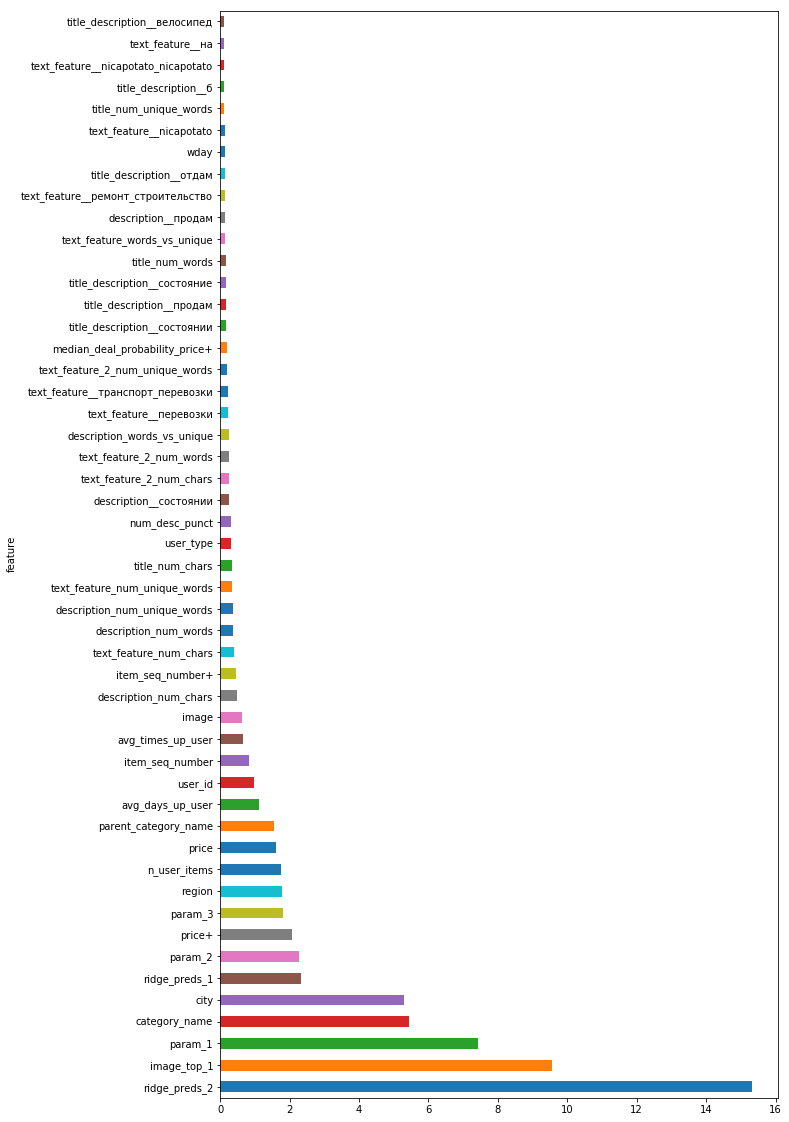

In [9]:
from nltk.corpus import stopwords 
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import FeatureUnion
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.cross_validation import KFold
from sklearn.linear_model import Ridge
from scipy.sparse import hstack, csr_matrix
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import gc, re
from sklearn.utils import shuffle
from contextlib import contextmanager
from sklearn.externals import joblib
import pickle

def rmse(predictions, targets):
    print("calculating RMSE ...")
    return np.sqrt(((predictions - targets) ** 2).mean())

print('Loading pickled data')
with open('X.p', 'rb') as f:
    X = pickle.load(f)   
with open('test.p', 'rb') as f:
    test = pickle.load(f)   
with open('tfvocab.p', 'rb') as f:
    tfvocab = pickle.load(f)
with open('y.p', 'rb') as f:
    y = pickle.load(f)

    
    
    
    
    
    
    
    
    
    
    
    
    
    
    
print("Load model ...")
lgb_clf = joblib.load("lgb_0.pkl")
      ## load model
rmse_sume = 0.

X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.1, random_state=42)
      
print("Model Evaluation Stage")
print( "RMSE:", rmse(y_valid, lgb_clf.predict(X_valid, num_iteration=lgb_clf.best_iteration)) )
lgpred = lgb_clf.predict(test, num_iteration=lgb_clf.best_iteration)
      
lgsub = pd.DataFrame(lgpred,columns=["deal_probability"],index=sub_item_id)
lgsub["deal_probability"].clip(0.0, 1.0, inplace=True) # Between 0 and 1
lgsub.to_csv("ml_lgb_sub_target_encoding.csv",index=True,header=True)

rmse_sume += rmse(y_valid, lgb_clf.predict(X_valid, num_iteration=lgb_clf.best_iteration))
      
numIter += 1
      
del X_train, X_valid, y_train, y_valid, lgtrain, lgvalid
gc.collect()

print("mean rmse is:", rmse_sume/5)
      
print("Features importance...")
bst = lgb_clf
gain = bst.feature_importance("gain")
ft = pd.DataFrame({"feature":bst.feature_name(), "split":bst.feature_importance("split"), "gain":100 * gain / gain.sum()}).sort_values("gain", ascending=False)
print(ft.head(50))

plt.figure()
ft[["feature","gain"]].head(50).plot(kind="barh", x="feature", y="gain", legend=False, figsize=(10, 20))
plt.gcf().savefig("features_importance.png")

print("Done.")